# Time series applied on kma real dataset

Importation librairies

In [1]:
!pip install pandas matplotlib scikit-learn statsmodels prophet


  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/c7/ef/925617d36c08e0bbdf4347a9b38974ce7ab8fdb5d1a5cf0e3f3c65ea43da/prophet-1.1.7-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/2a/80/04b3989f055e555737b3b6944f02112e90cfc4f2e53c763771dded22e684/cmdstanpy-1.2.5-py3-none-any.whl.metadata
  Obtaining dependency information for holidays<1,>=0.25 from https://files.pythonhosted.org/packages/65/9c/01da17421bd6a0aa230839b8313fa1615c81555f94954350fca4f4b7f129/holidays-0.73-py3-none-any.whl.metadata
  Obtaining dependency information for importlib_resources from https://files.pythonhosted.org/packages/a4/ed/1f1afb2e9e7f38a545d628f864d562a5ae64fe6f7a10e28ffb9b185b4e89/importlib_resources-6.5.2-py3-none-any.whl.metadata
  Obtaining dependency information for stanio<2.0.0,>=0.4.0 from https://files.pythonhosted.org/packages/56/87/37a80e4d5bd453c33262d8fb618b6840fd98d24ed

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from math import sqrt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import pairwise_distances

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

Codes

In [4]:
df_train = pd.read_csv("kma_train.csv")

date_range = pd.date_range(start='2000-01-01', end='2024-12-31', freq='D')
df_train['original_date'] = pd.Series(date_range[:len(df_train)])
df_train['date'] = df_train['original_date']
df_train.drop(columns='original_date', inplace=True)

df_train['date'] = pd.to_datetime(df_train['date'], errors='coerce')


df_test = pd.read_csv('kma_test.csv')

date_range = pd.date_range(start='2025-01-01', end='2025-06-04', freq='D')
df_test['original_date'] = pd.Series(date_range[:len(df_test)])
df_test['date'] = df_test['original_date']
df_test.drop(columns='original_date', inplace=True)

df_test['date'] = pd.to_datetime(df_test['date'], errors='coerce')


In [5]:
df_test

,id,date,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,2025-01-01,0.602865,-0.455100,-0.628280,-0.741405,-0.395073,0.328948,-0.436094,-0.348016,0.561824,-0.042543,0.0
1,1,2025-01-02,0.952096,-0.771230,-0.872641,-0.790301,-1.091945,-0.876508,-1.016028,0.486779,0.763405,-0.194134,0.0
2,2,2025-01-03,1.089293,-1.076458,-1.058820,-1.059229,-1.114068,-0.627640,-0.275001,0.167593,0.763405,-0.421521,0.0
3,3,2025-01-04,1.139183,-0.803933,-0.942458,-1.095901,-1.091945,-0.814291,-0.822716,0.216698,-1.453981,-1.255272,0.0
4,4,2025-01-05,0.278580,-1.152766,-0.791187,-0.521373,-0.129598,1.938815,1.754768,-1.722973,-1.453981,-1.255272,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,150,2025-05-31,-0.731694,1.517985,1.570963,1.568931,1.297331,-0.394326,0.691556,0.069381,-1.453981,-1.179476,0.0
151,151,2025-06-01,-0.943727,1.768709,1.698961,1.642275,1.474315,-0.176566,-0.146127,0.953282,0.763405,-0.345725,0.0
152,152,2025-06-02,-1.617243,1.092845,1.512782,1.911203,1.540683,0.328948,1.883642,-1.722973,0.763405,-1.255272,0.0
153,153,2025-06-03,-2.116144,1.332668,1.501146,1.642275,1.286270,-0.246560,-0.758279,1.198810,0.561824,0.563821,0.0


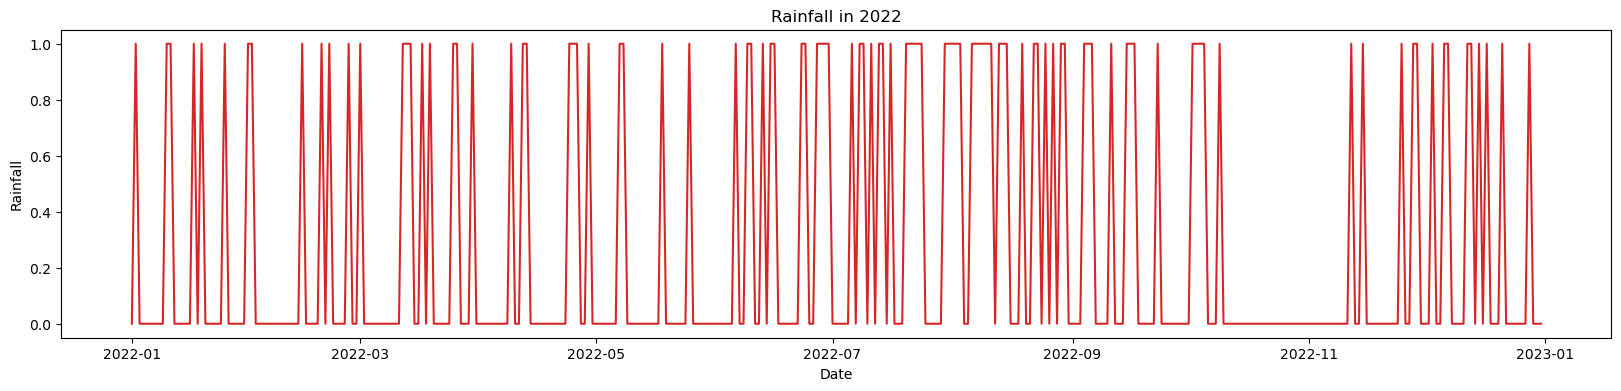

In [15]:
#Visualisation
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Rainfall', dpi=100):
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
df_copyy = df_train.copy()
df_copyy.set_index('date', inplace=True)
df_copyy = df_copyy['2022-01-01':'2022-12-31']
df_copyy.reset_index(inplace=True)

plot_df(df_train, x=df_copyy['date'], y=df_copyy['rainfall'], title='Rainfall in 2022')


In [16]:
df_arima_train = df_train[['date', 'rainfall']].dropna()
df_arima_train

,date,rainfall
0,2000-01-01,0.0
1,2000-01-02,1.0
2,2000-01-03,0.0
3,2000-01-04,0.0
4,2000-01-05,1.0
...,...,...
9127,2024-12-27,0.0
9128,2024-12-28,0.0
9129,2024-12-29,0.0
9130,2024-12-30,0.0


ARIMA

In [17]:
df_arima_train['rainfall_log'] = np.log1p(df_arima_train['rainfall']) 
df_arima_train = df_arima_train.set_index('date').asfreq('D').fillna(0)

df_arima_test = df_test[['date', 'rainfall']].dropna()
df_arima_test['rainfall_log'] = np.log1p(df_arima_test['rainfall']) 
df_arima_test = df_arima_test.set_index('date').asfreq('D').fillna(0)

df_arima_test

,rainfall,rainfall_log
date,,
2025-01-01,0.0,0.000000
2025-01-02,0.0,0.000000
2025-01-03,0.0,0.000000
2025-01-04,0.0,0.000000
2025-01-05,1.0,0.693147
...,...,...
2025-05-31,0.0,0.000000
2025-06-01,0.0,0.000000
2025-06-02,0.0,0.000000



ARIMA (predict rainfall based on previous value of rainfall)
MSE on validation : 0.2516
RMSE on validation : 0.5016
MAE on validation : 0.2516


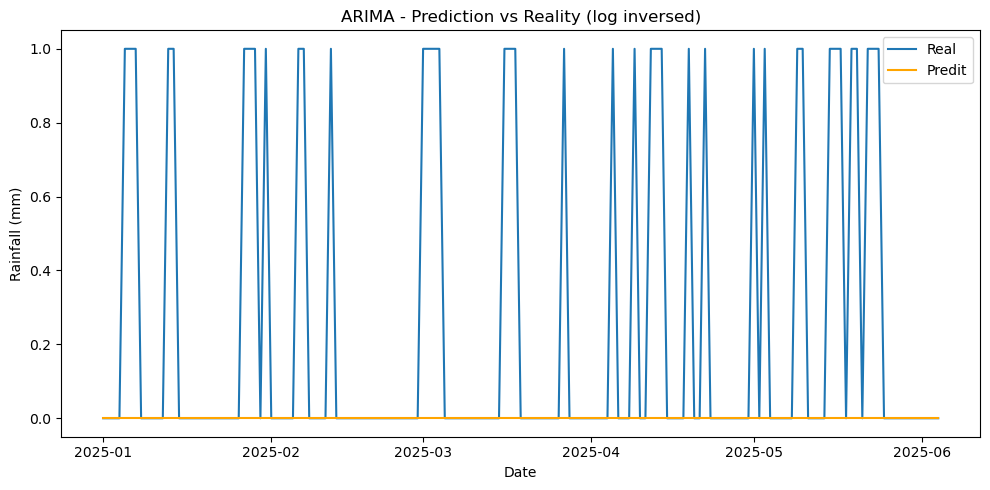

In [18]:
print("\nARIMA (predict rainfall based on previous value of rainfall)")
arima_model = ARIMA(df_arima_train['rainfall_log'], order=(5, 1, 0))
arima_result = arima_model.fit()

arima_pred_log = arima_result.predict(start=df_arima_test.index[0], end=df_arima_test.index[-1])
arima_pred = np.expm1(arima_pred_log)

true_values = df_arima_test['rainfall']
rmse_arima = np.sqrt(mean_squared_error(true_values, arima_pred))
mae_arima = mean_absolute_error(true_values, arima_pred)
mse_arima = mean_squared_error(true_values, arima_pred)
print(f"MSE on validation : {mse_arima:.4f}")
print(f"RMSE on validation : {rmse_arima:.4f}")
print(f"MAE on validation : {mae_arima:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(true_values.index, true_values, label="Real")
plt.plot(arima_pred.index, arima_pred, label="Predit", color="orange")
plt.title("ARIMA - Prediction vs Reality (log inversed)")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.tight_layout()
plt.show()


SARIMAX 

In [19]:
df_sarimax_train = df_train.dropna()
df_sarimax_train = df_sarimax_train.sort_values(by='date') 
df_sarimax_train = df_sarimax_train.groupby('date').sum().reset_index()
df_sarimax_train = df_sarimax_train.set_index('date').asfreq('D').fillna(0)
df_sarimax_train = df_sarimax_train.fillna(method='ffill').fillna(method='bfill')

train_X = df_sarimax_train.drop(columns='rainfall')
train_y = df_sarimax_train['rainfall']
print(train_X)
print(train_y)

df_sarimax_test = df_test.dropna()
df_sarimax_test = df_sarimax_test.sort_values(by='date') 
df_sarimax_test = df_sarimax_test.groupby('date').sum().reset_index()
df_sarimax_test = df_sarimax_test.set_index('date').asfreq('D').fillna(0)
df_sarimax_test = df_sarimax_test.fillna(method='ffill').fillna(method='bfill')

test_X = df_sarimax_test.drop(columns='rainfall')
test_y =  df_sarimax_test['rainfall']
print(test_X)
print(test_y)

              id  pressure   maxtemp  temparature   mintemp  dewpoint  \
date                                                                    
2000-01-01     0  0.627599 -0.727087    -0.723225 -0.695913 -0.524695   
2000-01-02     1  0.002677 -1.007530    -0.846763 -0.949539 -0.449288   
2000-01-03     2  0.482800 -1.643202    -1.454951 -1.297100 -1.362541   
2000-01-04     3  0.642841 -1.250581    -1.217378 -1.268920 -1.262000   
2000-01-05     4  0.177960 -1.222537    -0.979804 -0.855604 -0.440910   
...          ...       ...       ...          ...       ...       ...   
2024-12-27  9127  0.688567 -1.484284    -1.492963 -1.419216 -1.387677   
2024-12-28  9128  0.559010 -1.549721    -1.530975 -1.494365 -1.479840   
2024-12-29  9129  0.589494 -1.082315    -1.141354 -1.259526 -1.010646   
2024-12-30  9130  0.116992 -0.708391    -0.723225 -0.686520 -0.424153   
2024-12-31  9131  0.330380 -1.194492    -1.188869 -1.052868 -1.270378   

            humidity     cloud  sunshine  winddire

In [20]:
print(test_X['id'])

date
2025-01-01      0
2025-01-02      1
2025-01-03      2
2025-01-04      3
2025-01-05      4
             ... 
2025-05-31    150
2025-06-01    151
2025-06-02    152
2025-06-03    153
2025-06-04    154
Freq: D, Name: id, Length: 155, dtype: int64



SARIMAX


C:\Users\hindi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE on validation : 0.0976
RMSE on validation : 0.3124
MAE on validation : 0.2308


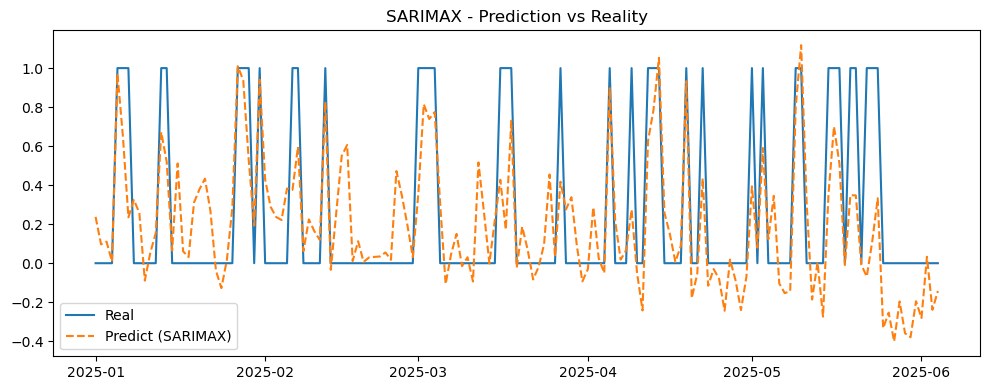

In [21]:

print("\nSARIMAX")
sarimax_model = SARIMAX(train_y, exog=train_X,order=(1, 1, 1))
sarimax_result = sarimax_model.fit(disp=False)

sarimax_pred = sarimax_result.predict(start=test_y.index[0], end=test_y.index[-1], exog=test_X)

rmse_sarimax = np.sqrt(mean_squared_error(test_y, sarimax_pred))
mae_sarimax = mean_absolute_error(test_y, sarimax_pred)
mse_sarimax = mean_squared_error(test_y, sarimax_pred)
print(f"MSE on validation : {mse_sarimax:.4f}")
print(f"RMSE on validation : {rmse_sarimax:.4f}")
print(f"MAE on validation : {mae_sarimax:.4f}")


plt.figure(figsize=(10, 4))
plt.plot(test_y.index, test_y, label='Real')
plt.plot(test_y.index, sarimax_pred, label='Predict (SARIMAX)', linestyle='--')
plt.title("SARIMAX - Prediction vs Reality")
plt.legend()
plt.tight_layout()
plt.show()


And now if we convert the result as binary (to have rain or not) if rainfall>0.5

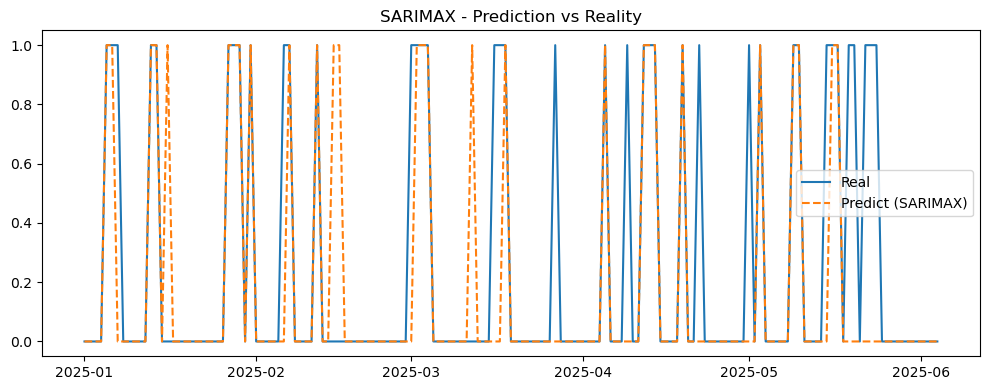

MSE on validation : 0.1226
RMSE on validation : 0.3501
MAE on validation : 0.1226


In [22]:
def binarize_predictions(y_pred, y_true=None, threshold=0.1, display_metrics=True):
    """
    Convertit des prédictions continues en binaire (0/1) selon un seuil.
    Optionnel : compare aux vraies valeurs et affiche des métriques.

    Parameters:
    - y_pred : array-like, prédictions continues (ex: sorties de SARIMAX)
    - y_true : array-like ou None, vraies valeurs binaires pour comparaison
    - threshold : float, seuil à partir duquel on considère qu'il pleut
    - display_metrics : bool, afficher les scores de classification

    Returns:
    - y_pred_binary : array de 0 ou 1
    """
    y_pred = np.asarray(y_pred)
    y_pred_binary = (y_pred > threshold).astype(int)

    if y_true is not None:
        y_true = np.asarray(y_true)
        if display_metrics:
            acc = accuracy_score(y_true, y_pred_binary)
            f1 = f1_score(y_true, y_pred_binary)
            cm = confusion_matrix(y_true, y_pred_binary)
            print(f"\n🔍 Binarisation (seuil = {threshold} mm)")
            print(f"Accuracy : {acc:.3f}")
            print(f"F1-score : {f1:.3f}")
            print("Confusion Matrix :\n", cm)

    return y_pred_binary

y_pred_binary = binarize_predictions(sarimax_pred, threshold = 0.5)
arimax_future_df = pd.DataFrame({
    "date": test_X['id'],  # ou future_X["date"] si c'est une colonne
    "rainfall": y_pred_binary
    })
arimax_future_df.to_csv('arimax_future_df.csv', index=False )

plt.figure(figsize=(10, 4))
plt.plot(test_y.index, test_y, label='Real')
plt.plot(test_y.index, y_pred_binary, label='Predict (SARIMAX)', linestyle='--')
plt.title("SARIMAX - Prediction vs Reality")
plt.legend()
plt.tight_layout()
plt.show()

rmse_sarimax = np.sqrt(mean_squared_error(test_y, y_pred_binary))
mae_sarimax = mean_absolute_error(test_y, y_pred_binary)
mse_sarimax = mean_squared_error(test_y, y_pred_binary)
print(f"MSE on validation : {mse_sarimax:.4f}")
print(f"RMSE on validation : {rmse_sarimax:.4f}")
print(f"MAE on validation : {mae_sarimax:.4f}")


Try to keep only the interesting variables : 

In [23]:
corr = df_sarimax_train.corr()
print(corr['rainfall'].sort_values(ascending=False))
filtered_names = corr['rainfall'][corr['rainfall'] > 0.1].index.tolist()
df_sarimax_train_reduce = df_sarimax_train[filtered_names]
df_sarimax_test_reduce = df_sarimax_test[filtered_names]
print(filtered_names)
print(df_sarimax_train_reduce)
print(df_sarimax_test_reduce)

rainfall         1.000000
cloud            0.590017
humidity         0.572231
dewpoint         0.290781
mintemp          0.199814
windspeed        0.184100
temparature      0.140305
maxtemp          0.076147
id              -0.001889
winddirection   -0.158664
pressure        -0.217800
sunshine        -0.554654
Name: rainfall, dtype: float64
['temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'windspeed', 'rainfall']
            temparature   mintemp  dewpoint  humidity     cloud  windspeed  \
date                                                                         
2000-01-01    -0.723225 -0.695913 -0.524695  0.137597 -0.107539  -0.638778   
2000-01-02    -0.846763 -0.949539 -0.449288  0.863480  0.210894   1.825426   
2000-01-03    -1.454951 -1.297100 -1.362541 -0.494190 -1.285743   0.661774   
2000-01-04    -1.217378 -1.268920 -1.262000 -0.863852 -0.330443  -1.323279   
2000-01-05    -0.979804 -0.855604 -0.440910  1.488546  1.643844   0.182624   
...                 ...   


SARIMAX


C:\Users\hindi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX - MSE on validation : 0.0872
RMSE on validation : 0.2954
MAE on validation : 0.2246


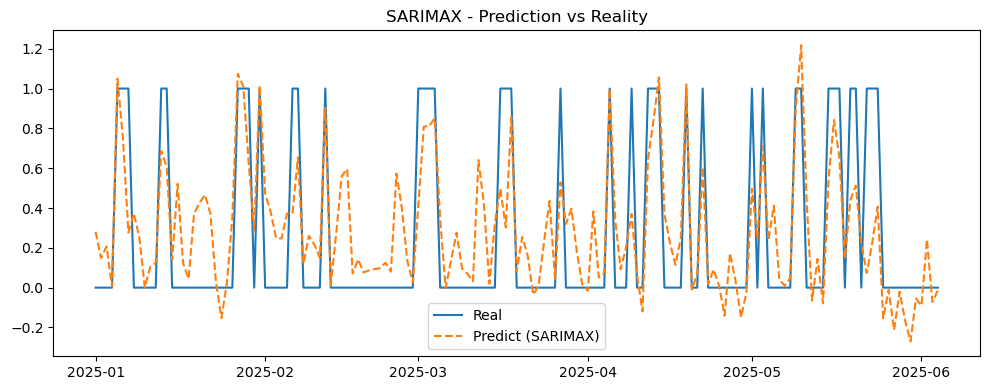

SARIMAX - MSE on validation : 0.1032
RMSE on validation : 0.3213
MAE on validation : 0.1032


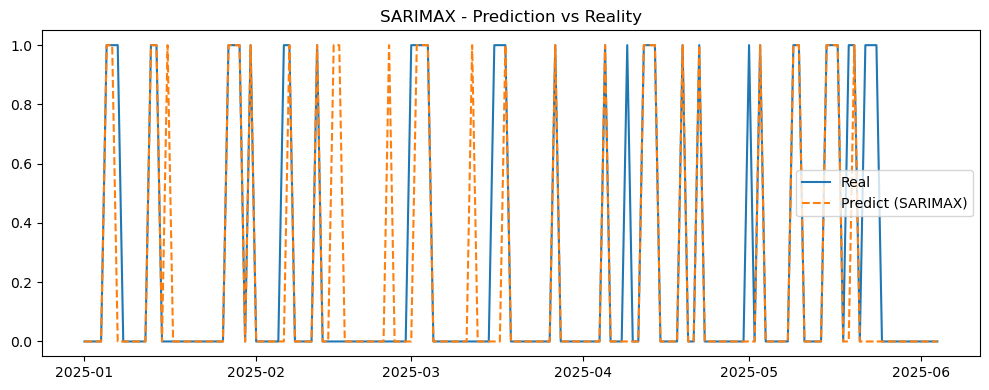

In [24]:
train_X = df_sarimax_train_reduce.drop(columns = "rainfall")
train_y = df_sarimax_train_reduce['rainfall']
test_X = df_sarimax_test_reduce.drop(columns = 'rainfall')
test_y = df_sarimax_test_reduce['rainfall']


print("\nSARIMAX")
arimax_model = SARIMAX(train_y, exog=train_X,order=(1, 1, 1))
arimax_result = arimax_model.fit(disp=False)

arimax_pred = arimax_result.predict(start=test_y.index[0], end=test_y.index[-1], exog=test_X)

rmse_arimax = np.sqrt(mean_squared_error(test_y, arimax_pred))
mae_arimax = mean_absolute_error(test_y, arimax_pred)
mse_arimax = mean_squared_error(test_y, arimax_pred)
print(f"SARIMAX - MSE on validation : {mse_arimax:.4f}")
print(f"RMSE on validation : {rmse_arimax:.4f}")
print(f"MAE on validation : {mae_arimax:.4f}")


plt.figure(figsize=(10, 4))
plt.plot(test_y.index, test_y, label='Real')
plt.plot(test_y.index, arimax_pred, label='Predict (SARIMAX)', linestyle='--')
plt.title("SARIMAX - Prediction vs Reality")
plt.legend()
plt.tight_layout()
plt.show()


y_pred_binary = binarize_predictions(arimax_pred, threshold = 0.5)
rmse_arimax = np.sqrt(mean_squared_error(test_y, y_pred_binary))
mae_arimax = mean_absolute_error(test_y, y_pred_binary)
mse_arimax = mean_squared_error(test_y, y_pred_binary)
print(f"SARIMAX - MSE on validation : {mse_arimax:.4f}")
print(f"RMSE on validation : {rmse_arimax:.4f}")
print(f"MAE on validation : {mae_arimax:.4f}")


plt.figure(figsize=(10, 4))
plt.plot(test_y.index, test_y, label='Real')
plt.plot(test_y.index, y_pred_binary, label='Predict (SARIMAX)', linestyle='--')
plt.title("SARIMAX - Prediction vs Reality")
plt.legend()
plt.tight_layout()
plt.show()

PROPHET


Prophet


10:49:24 - cmdstanpy - INFO - Chain [1] start processing
10:49:26 - cmdstanpy - INFO - Chain [1] done processing


Index(['ds', 'y'], dtype='object')
Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


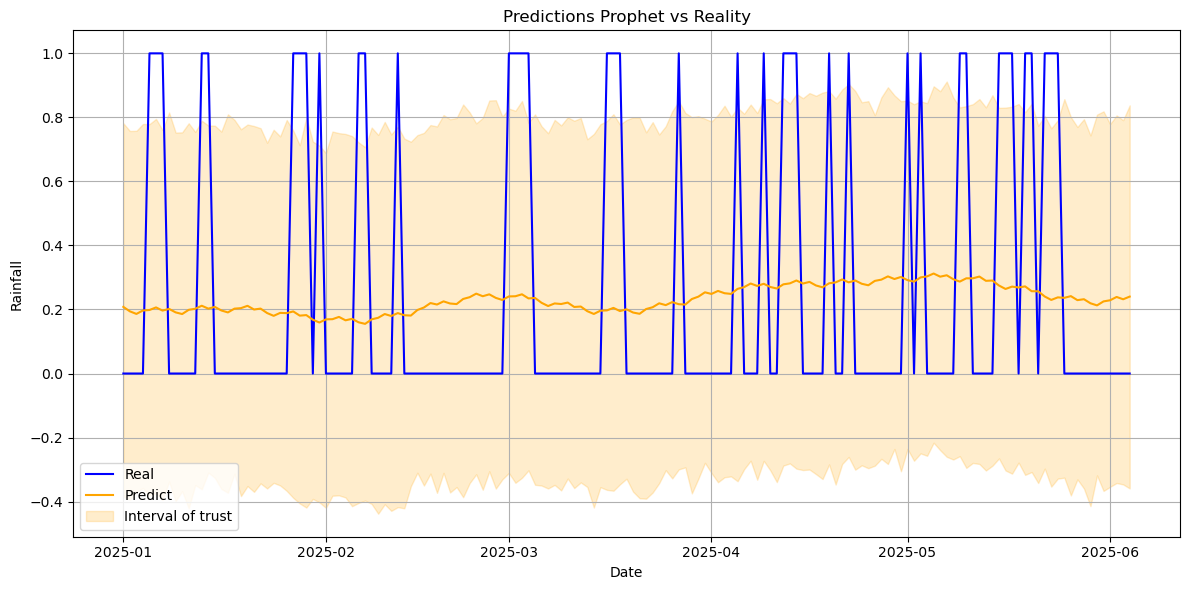

PROPHET - MSE on validation : 0.5832
RMSE on validation : 0.7637
MAE on validation : 0.5599


In [25]:
print("\nProphet")
df_prophet_train = df_train[['date', 'rainfall']].dropna()
df_prophet_train = df_prophet_train.rename(columns={'date': 'ds', 'rainfall': 'y'})
df_prophet_test = df_test[['date', 'rainfall']].dropna()
df_prophet_test = df_prophet_test.rename(columns={'date': 'ds', 'rainfall': 'y'})

model_prophet = Prophet(daily_seasonality=True, yearly_seasonality=True)
model_prophet.fit(df_prophet_train)

future = df_prophet_test[['ds']]
forecast = model_prophet.predict(future)
print(df_prophet_test.columns)
print(forecast.columns)

plt.figure(figsize=(12, 6))
plt.plot(df_prophet_test['ds'], df_prophet_test['y'], label='Real', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Predict', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2, label='Interval of trust')
plt.title("Predictions Prophet vs Reality")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

eval_df = forecast[['ds', 'yhat']].merge(df_prophet_test[['ds', 'y']], on='ds')
eval_df['y_true'] = np.expm1(eval_df['y'])
eval_df['y_pred'] = np.expm1(eval_df['yhat'])

rmse_prophet = np.sqrt(mean_squared_error(eval_df['y_true'], eval_df['y_pred']))
mae_prophet = mean_absolute_error(eval_df['y_true'], eval_df['y_pred'])
mse_prophet = mean_squared_error(eval_df['y_true'], eval_df['y_pred'])
print(f"PROPHET - MSE on validation : {mse_prophet:.4f}")
print(f"RMSE on validation : {rmse_prophet:.4f}")
print(f"MAE on validation : {mae_prophet:.4f}")


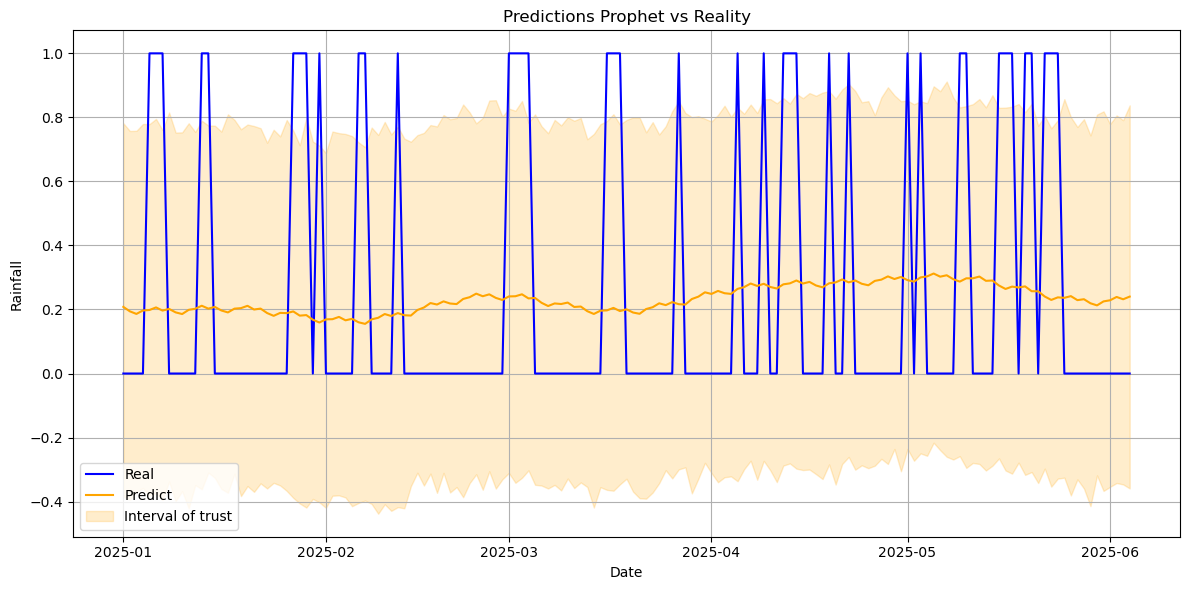

PROPHET - MSE on validation : 0.5832
RMSE on validation : 0.7637
MAE on validation : 0.5599


In [26]:
forecast['rain'] = (forecast['yhat'] > 0.1).astype(int)

plt.figure(figsize=(12, 6))
plt.plot(df_prophet_test['ds'], df_prophet_test['y'], label='Real', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Predict', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2, label='Interval of trust')
plt.title("Predictions Prophet vs Reality")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

eval_df = forecast[['ds', 'yhat']].merge(df_prophet_test[['ds', 'y']], on='ds')
eval_df['y_true'] = np.expm1(eval_df['y'])
eval_df['y_pred'] = np.expm1(eval_df['yhat'])

rmse_prophet = np.sqrt(mean_squared_error(eval_df['y_true'], eval_df['y_pred']))
mae_prophet = mean_absolute_error(eval_df['y_true'], eval_df['y_pred'])
mse_prophet = mean_squared_error(eval_df['y_true'], eval_df['y_pred'])
print(f"PROPHET - MSE on validation : {mse_prophet:.4f}")
print(f"RMSE on validation : {rmse_prophet:.4f}")
print(f"MAE on validation : {mae_prophet:.4f}")


Prophet with log(1+x)


Prophet based on log(1+x)


10:50:04 - cmdstanpy - INFO - Chain [1] start processing
10:50:05 - cmdstanpy - INFO - Chain [1] done processing


Index(['id', 'ds', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'y'],
      dtype='object')
Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


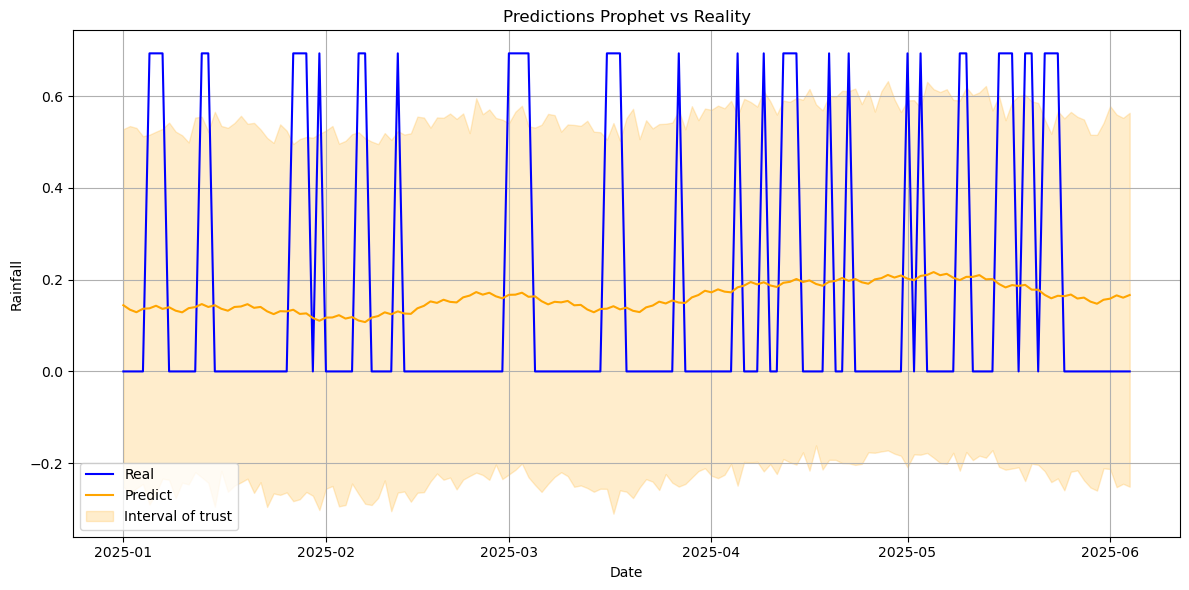

PROPHET - MSE on validation : 0.1936
RMSE on validation : 0.4400
MAE on validation : 0.3368


In [27]:
print("\nProphet based on log(1+x)")
df_prophet_train = df_train.copy()
df_prophet_train = df_prophet_train.rename(columns={'date': 'ds', 'rainfall': 'y'})
df_prophet_test = df_test.copy()
df_prophet_test = df_prophet_test.rename(columns={'date': 'ds', 'rainfall': 'y'})

df_prophet_train['y'] = np.log1p(df_prophet_train['y'])
df_prophet_test['y'] = np.log1p(df_prophet_test['y'])

model_prophet = Prophet(daily_seasonality=True, yearly_seasonality=True)
model_prophet.fit(df_prophet_train)

future = df_prophet_test[['ds']]
forecast = model_prophet.predict(future)
print(df_prophet_test.columns)
print(forecast.columns)

plt.figure(figsize=(12, 6))
plt.plot(df_prophet_test['ds'], df_prophet_test['y'], label='Real', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Predict', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2, label='Interval of trust')
plt.title("Predictions Prophet vs Reality")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

eval_df = forecast[['ds', 'yhat']].merge(df_prophet_test[['ds', 'y']], on='ds')
eval_df['y_true'] = np.expm1(eval_df['y'])
eval_df['y_pred'] = np.expm1(eval_df['yhat'])

rmse_prophet = np.sqrt(mean_squared_error(eval_df['y_true'], eval_df['y_pred']))
mae_prophet = mean_absolute_error(eval_df['y_true'], eval_df['y_pred'])
mse_prophet = mean_squared_error(eval_df['y_true'], eval_df['y_pred'])
print(f"PROPHET - MSE on validation : {mse_prophet:.4f}")
print(f"RMSE on validation : {rmse_prophet:.4f}")
print(f"MAE on validation : {mae_prophet:.4f}")

Prophet with another features

In [28]:
# 1st : taking only the interesting features 
corr = df_train.corr()
print(corr['rainfall'].sort_values(ascending=False))
filtered_names = corr['rainfall'][corr['rainfall'] > 0.1].index.tolist()
filtered_names.append('date')
df_train_reduce = df_train[filtered_names]
df_test_reduce = df_test[filtered_names]
print(filtered_names)
print(df_train_reduce)
print(df_test_reduce)

rainfall         1.000000
cloud            0.590017
humidity         0.572231
dewpoint         0.290781
mintemp          0.199814
windspeed        0.184100
temparature      0.140305
maxtemp          0.076147
id              -0.001889
date            -0.001889
winddirection   -0.158664
pressure        -0.217800
sunshine        -0.554654
Name: rainfall, dtype: float64
['temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'windspeed', 'rainfall', 'date']
      temparature   mintemp  dewpoint  humidity     cloud  windspeed  \
0       -0.723225 -0.695913 -0.524695  0.137597 -0.107539  -0.638778   
1       -0.846763 -0.949539 -0.449288  0.863480  0.210894   1.825426   
2       -1.454951 -1.297100 -1.362541 -0.494190 -1.285743   0.661774   
3       -1.217378 -1.268920 -1.262000 -0.863852 -0.330443  -1.323279   
4       -0.979804 -0.855604 -0.440910  1.488546  1.643844   0.182624   
...           ...       ...       ...       ...       ...        ...   
9127    -1.492963 -1.419216 -1.387

In [29]:
print(df_prophet_test)

      id         ds  pressure   maxtemp  temparature   mintemp  dewpoint  \
0      0 2025-01-01  0.602865 -0.455100    -0.628280 -0.741405 -0.395073   
1      1 2025-01-02  0.952096 -0.771230    -0.872641 -0.790301 -1.091945   
2      2 2025-01-03  1.089293 -1.076458    -1.058820 -1.059229 -1.114068   
3      3 2025-01-04  1.139183 -0.803933    -0.942458 -1.095901 -1.091945   
4      4 2025-01-05  0.278580 -1.152766    -0.791187 -0.521373 -0.129598   
..   ...        ...       ...       ...          ...       ...       ...   
150  150 2025-05-31 -0.731694  1.517985     1.570963  1.568931  1.297331   
151  151 2025-06-01 -0.943727  1.768709     1.698961  1.642275  1.474315   
152  152 2025-06-02 -1.617243  1.092845     1.512782  1.911203  1.540683   
153  153 2025-06-03 -2.116144  1.332668     1.501146  1.642275  1.286270   
154  154 2025-06-04 -1.592298  1.332668     1.454601  1.422243  1.175655   

     humidity     cloud  sunshine  winddirection  windspeed         y  
0    0.328948 -


Prophet based on other features


10:50:18 - cmdstanpy - INFO - Chain [1] start processing
10:50:20 - cmdstanpy - INFO - Chain [1] done processing


     temparature   mintemp  dewpoint  humidity     cloud  windspeed         ds
0      -0.628280 -0.741405 -0.395073  0.328948 -0.436094  -0.042543 2025-01-01
1      -0.872641 -0.790301 -1.091945 -0.876508 -1.016028  -0.194134 2025-01-02
2      -1.058820 -1.059229 -1.114068 -0.627640 -0.275001  -0.421521 2025-01-03
3      -0.942458 -1.095901 -1.091945 -0.814291 -0.822716  -1.255272 2025-01-04
4      -0.791187 -0.521373 -0.129598  1.938815  1.754768  -1.255272 2025-01-05
..           ...       ...       ...       ...       ...        ...        ...
150     1.570963  1.568931  1.297331 -0.394326  0.691556  -1.179476 2025-05-31
151     1.698961  1.642275  1.474315 -0.176566 -0.146127  -0.345725 2025-06-01
152     1.512782  1.911203  1.540683  0.328948  1.883642  -1.255272 2025-06-02
153     1.501146  1.642275  1.286270 -0.246560 -0.758279   0.563821 2025-06-03
154     1.454601  1.422243  1.175655 -0.370994 -1.144902   2.003936 2025-06-04

[155 rows x 7 columns]
            ds     trend  yh

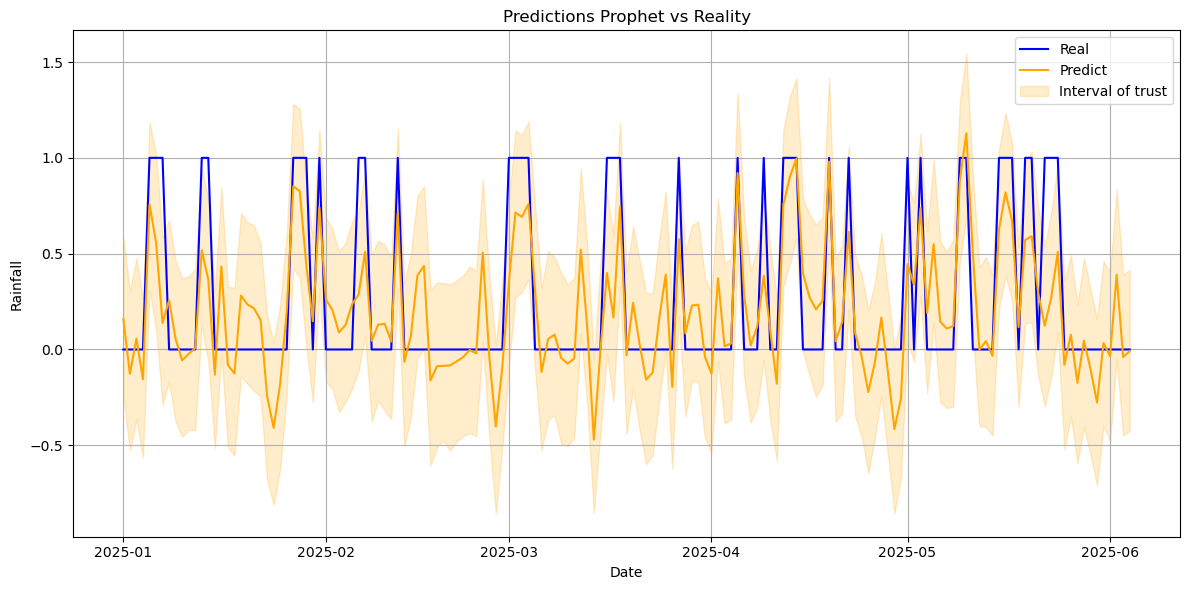

PROPHET - MSE on validation : 0.2600
RMSE on validation : 0.5099
MAE on validation : 0.3409
[0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 1 0]
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        30
           1       0.62      0.56      0.59         9

    accuracy                           0.82        39
   macro avg       0.75      0.73      0.74        39
weighted avg       0.81      0.82      0.82        39



In [30]:
print("\nProphet based on other features")
df_prophet_train = df_train_reduce.copy()
df_prophet_train = df_prophet_train.rename(columns={'date': 'ds', 'rainfall': 'y'})
df_prophet_test = df_test_reduce.copy()
df_prophet_test = df_prophet_test.rename(columns={'date': 'ds', 'rainfall': 'y'})
df_prophet_test = df_prophet_test.fillna(method='ffill').fillna(method='bfill')
df_prophet_train = df_prophet_train.fillna(method='ffill').fillna(method='bfill')

model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.add_regressor('temparature')
model.add_regressor('humidity')
model.add_regressor('cloud')
model.add_regressor('windspeed') 
model.fit(df_prophet_train)

#future = model.make_future_dataframe(periods=0)
future = df_prophet_test.copy()
future = future.drop(columns = 'y')
print(future)
forecast = model.predict(future)
print(forecast)

plt.figure(figsize=(12, 6))
plt.plot(df_prophet_test['ds'], df_test_reduce['rainfall'], label='Real', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Predict', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2, label='Interval of trust')
plt.title("Predictions Prophet vs Reality")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

eval_df = forecast[['ds', 'yhat']].merge(df_prophet_test[['ds', 'y']], on='ds')
eval_df['y_true'] = np.expm1(eval_df['y'])
eval_df['y_pred'] = np.expm1(eval_df['yhat'])

rmse_prophet = np.sqrt(mean_squared_error(eval_df['y_true'], eval_df['y_pred']))
mae_prophet = mean_absolute_error(eval_df['y_true'], eval_df['y_pred'])
mse_prophet = mean_squared_error(eval_df['y_true'], eval_df['y_pred'])
print(f"PROPHET - MSE on validation : {mse_prophet:.4f}")
print(f"RMSE on validation : {rmse_prophet:.4f}")
print(f"MAE on validation : {mae_prophet:.4f}")

X = forecast[['trend', 'weekly', 'yearly']]  
y = (df_test_reduce['rainfall'] > 0).astype(int)


from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(y_pred)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

prophet_lg_future_df = pd.DataFrame({
    "date": X_test.index, 
    "rainfall": y_pred
    })
prophet_lg_future_df.to_csv('prophet_lg_future_df.csv', index=False )

Comparison

ARIMA RMSE: 0.50
ARIMA MAE:  0.25
SARIMAX RMSE: 0.35
SARIMAX MAE:  0.12
Prophet RMSE: 0.51
Prophet MAE:  0.34


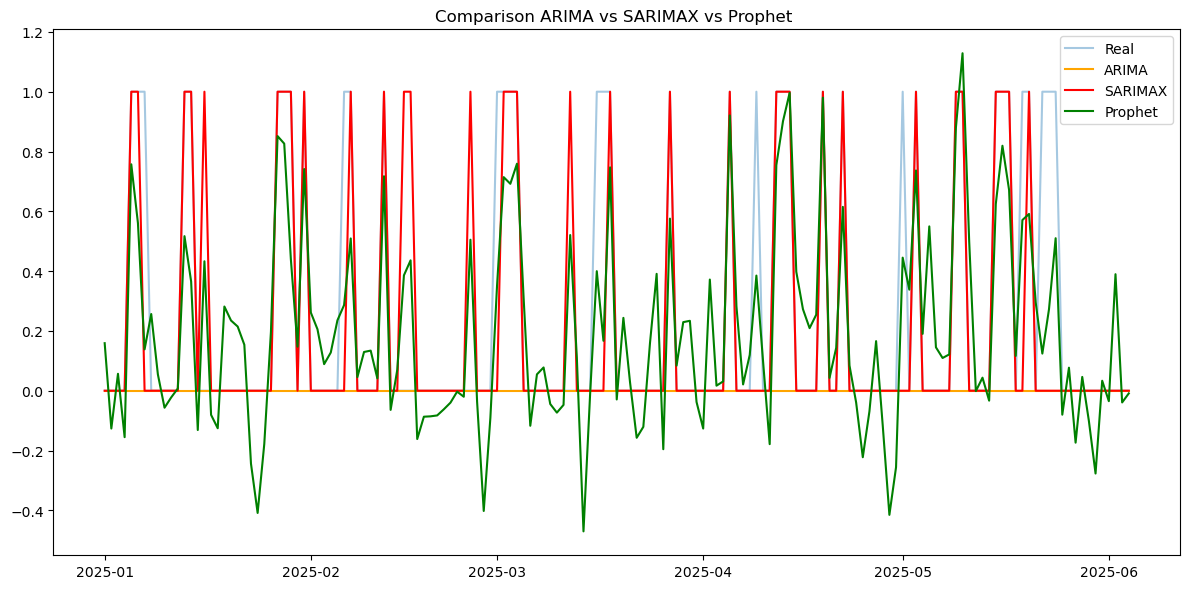

In [31]:
print(f"ARIMA RMSE: {rmse_arima:.2f}")
print(f"ARIMA MAE:  {mae_arima:.2f}")
print(f"SARIMAX RMSE: {rmse_sarimax:.2f}")
print(f"SARIMAX MAE:  {mae_sarimax:.2f}")
print(f"Prophet RMSE: {rmse_prophet:.2f}")
print(f"Prophet MAE:  {mae_prophet:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(sarimax_pred.index, df_test['rainfall'], label='Real', alpha=0.4)
plt.plot(arima_pred.index, arima_pred, label='ARIMA', color='orange')
plt.plot(sarimax_pred.index, y_pred_binary, label='SARIMAX', color='red')
plt.plot(sarimax_pred.index, forecast['yhat'].values, label='Prophet', color='green')
plt.title("Comparison ARIMA vs SARIMAX vs Prophet ")
plt.legend()
plt.tight_layout()
plt.show()

## Prediction

In [73]:
class CustomKNNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self

    def predict(self, X):
        X = np.array(X)
        distances = pairwise_distances(X, self.X_train, metric=self.metric)
        
        # Indices des k plus proches voisins
        neighbors_idx = np.argsort(distances, axis=1)[:, :self.n_neighbors]

        # Moyenne des cibles des voisins
        predictions = np.array([
            self.y_train[neighbors].mean()
            for neighbors in neighbors_idx
        ])

        return predictions


In [38]:
df_weather = pd.read_csv("weather.csv")
kma_train_proba = df_weather[df_weather['region']==108].copy()
kma_train_proba = kma_train_proba.sort_values('date').reset_index(drop=True)
print(kma_train_proba)
proba_rainfall = kma_train_proba['rainfall']

df_proba_rainfall = pd.DataFrame(proba_rainfall)
print(df_proba_rainfall)
df_proba_rainfall.index = df_future['2000-01-01':'2024-08-12'].index
print(df_proba_rainfall)


#kma_test_proba['date'] = pd.to_datetime(kma_test_proba["date"])
#kma_test_proba['date'].dt.strftime("%Y-%m-%d")
#kma_test_proba.set_index('date', inplace=True)
#kma_test_proba = kma_test_proba['2024-01-01':'2024-08-12']

         id        date  pressure  maxtemp  temparature  mintemp  dewpoint  \
0     89715  2000-01-01    1014.0      9.9          5.5      1.8      -1.1   
1     89716  2000-01-02    1005.8      6.9          4.2     -0.9      -0.2   
2     89717  2000-01-03    1012.1      0.1         -2.2     -4.6     -11.1   
3     89718  2000-01-04    1014.2      4.3          0.3     -4.3      -9.9   
4     89719  2000-01-05    1008.1      4.6          2.8      0.1      -0.1   
...     ...         ...       ...      ...          ...      ...       ...   
8986  98701  2024-08-08     994.7     31.6         28.5     26.9      24.1   
8987  98702  2024-08-09     994.2     33.6         29.3     25.6      24.0   
8988  98703  2024-08-10     993.0     33.6         30.0     26.4      23.8   
8989  98704  2024-08-11     992.5     34.4         30.8     27.8      24.0   
8990  98705  2024-08-12     994.5     34.1         31.1     28.2      24.9   

      humidity  cloud  sunshine  winddirection  windspeed  rain

In [39]:
print(df_future)

              id  pressure   maxtemp  temparature   mintemp  dewpoint  \
date                                                                    
2000-01-01     0  0.627599 -0.727087    -0.723225 -0.695913 -0.524695   
2000-01-02     1  0.002677 -1.007530    -0.846763 -0.949539 -0.449288   
2000-01-03     2  0.482800 -1.643202    -1.454951 -1.297100 -1.362541   
2000-01-04     3  0.642841 -1.250581    -1.217378 -1.268920 -1.262000   
2000-01-05     4  0.177960 -1.222537    -0.979804 -0.855604 -0.440910   
...          ...       ...       ...          ...       ...       ...   
2024-12-27  9127  0.688567 -1.484284    -1.492963 -1.419216 -1.387677   
2024-12-28  9128  0.559010 -1.549721    -1.530975 -1.494365 -1.479840   
2024-12-29  9129  0.589494 -1.082315    -1.141354 -1.259526 -1.010646   
2024-12-30  9130  0.116992 -0.708391    -0.723225 -0.686520 -0.424153   
2024-12-31  9131  0.330380 -1.194492    -1.188869 -1.052868 -1.270378   

            humidity     cloud  sunshine  winddire

In [47]:
df_proba_rainfall.loc['2024-08-08']

rainfall    0.0
Name: 2024-08-08 00:00:00, dtype: float64

# New way to see it

## 1. First classification : binary (whether it rains or not)
Based on Sarimax, 1 week of training, 2 days of predictions

IMPORTANT : 
The dataset is about region 108.
I don't know where they find the values but according to the original dataset (weather.csv), before standarization,  there are no data for 2025 so I only use the ones before and predicted for 2024 date, whose last register has been in 2024-08-12.

In [48]:
df_future = df_train.dropna()
df_future = df_future.sort_values(by='date')
future = df_future.groupby('date').sum().reset_index()
df_future = df_future.set_index('date').asfreq('D').fillna(0)
df_future = df_future.fillna(method='ffill').fillna(method='bfill')

train = df_future['2024-03-26':'2024-04-01']
train_X = train.drop(columns='rainfall')
train_y = train['rainfall']

future = df_future['2024-04-02':'2024-04-04']
future_X = future.drop(columns = 'rainfall')
future_y = future['rainfall']

print(train_X)
print(train_y)
print(future_X)
print(future_y)


              id  pressure   maxtemp  temparature   mintemp  dewpoint  \
date                                                                    
2024-03-26  8851  0.292275 -0.493384    -0.542669 -0.564404 -0.156042   
2024-03-27  8852  0.490421 -0.138156    -0.257581 -0.451681 -0.063879   
2024-03-28  8853 -0.469825 -0.512080    -0.267084 -0.132301  0.170718   
2024-03-29  8854 -0.675592 -0.502732    -0.523663 -0.395320 -0.197934   
2024-03-30  8855 -0.317405 -0.194245    -0.409628 -0.583191 -0.432532   
2024-03-31  8856 -0.264058  0.002066    -0.238575 -0.545617 -0.742535   
2024-04-01  8857 -0.104017  0.123591    -0.086528 -0.348352 -0.893347   

            humidity     cloud  sunshine  winddirection  windspeed  
date                                                                
2024-03-26  1.065114  0.401954 -0.901998      -1.246735   0.524874  
2024-03-27  0.466933  0.147207  0.748896      -1.246735  -0.364977  
2024-03-28  1.367565  1.166194 -1.486160      -1.246735  -0.364977

In [49]:
def Arimax_Future(train_X, train_y, future_X, future_y = None) : 
    arimax_model_future = SARIMAX(train_y, exog=train_X,order=(1, 1, 1))
    arimax_result_future = arimax_model_future.fit(disp=False)

    arimax_pred_future = arimax_result_future.predict(start=future_X.index[0], end=future_X.index[-1], exog=future_X)
    
    print(arimax_pred_future)
    arimax_future_df = pd.DataFrame({
    "date": future_X.index,  # ou future_X["date"] si c'est une colonne
    "rainfall": arimax_pred_future
    })
    arimax_future_df = arimax_future_df.set_index('date').asfreq('D').fillna(0)
    arimax_future_df.to_csv('arimax_future_df.csv', index=False )
    
    print(arimax_future_df)
    
    rmse_arimax = np.sqrt(mean_squared_error(future_y, arimax_pred_future))
    mae_arimax = mean_absolute_error(future_y, arimax_pred_future)
    mse_arimax = mean_squared_error(future_y, arimax_pred_future)
    print(f"SARIMAX - MSE on validation : {mse_arimax:.4f}")
    print(f"RMSE on validation : {rmse_arimax:.4f}")
    print(f"MAE on validation : {mae_arimax:.4f}")

    if future_y is not None : 
        plt.figure(figsize=(10, 4))
        plt.plot(future_y.index, future_y, label='Real')
        plt.plot(future_y.index, arimax_pred_future, label='Predict (SARIMAX)', linestyle='--')
        plt.title("SARIMAX - Prediction vs Reality")
        plt.legend()
        plt.tight_layout()
        plt.show()


        y_pred_binary_future = binarize_predictions(arimax_pred_future, threshold = 0.5)
        rmse_arimax = np.sqrt(mean_squared_error(future_y, y_pred_binary_future))
        mae_arimax = mean_absolute_error(future_y, y_pred_binary_future)
        mse_arimax = mean_squared_error(future_y, y_pred_binary_future)
        print(f"SARIMAX - MSE on validation : {mse_arimax:.4f}")
        print(f"RMSE on validation : {rmse_arimax:.4f}")
        print(f"MAE on validation : {mae_arimax:.4f}")


        plt.figure(figsize=(10, 4))
        plt.plot(future_y.index, future_y, label='Real')
        plt.plot(future_y.index, y_pred_binary_future, label='Predict (SARIMAX)', linestyle='--')
        plt.title("SARIMAX - Prediction vs Reality")
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    else : 
        plt.figure(figsize=(10, 4))
        plt.plot(test_X.index, arimax_pred_future, label='Predict (SARIMAX)', linestyle='--')
        plt.title("SARIMAX - Prediction")
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    return arimax_future_df

C:\Users\hindi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2024-04-02   -0.673620
2024-04-03    0.856173
2024-04-04    0.299072
Freq: D, Name: predicted_mean, dtype: float64
            rainfall
date                
2024-04-02 -0.673620
2024-04-03  0.856173
2024-04-04  0.299072
SARIMAX - MSE on validation : 0.4254
RMSE on validation : 0.6522
MAE on validation : 0.6096


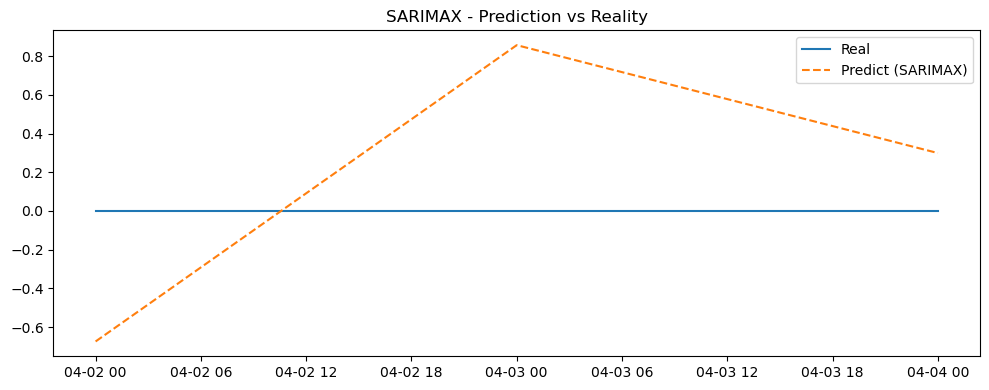

SARIMAX - MSE on validation : 0.3333
RMSE on validation : 0.5774
MAE on validation : 0.3333


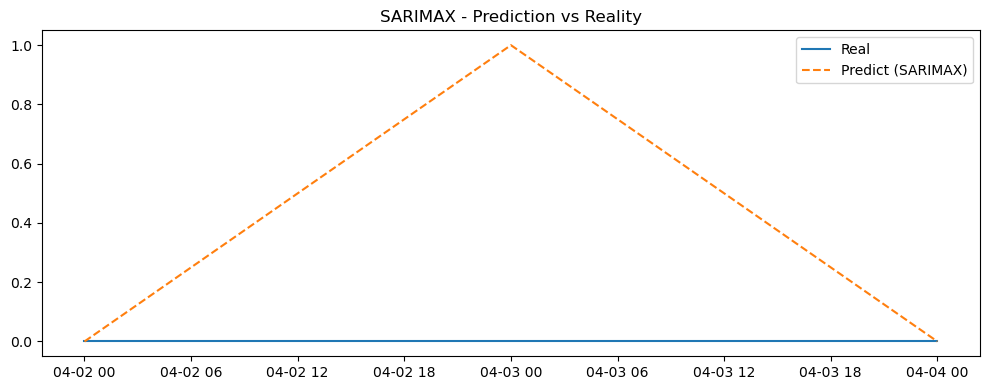

In [50]:
arimax_future_df = Arimax_Future(train_X, train_y, future_X, future_y = future_y)

## 2. Second classification : how many it rains (only on values that turned out 1 at first step)
Using linear regression : if it's raining, we apply linear regression to the original dataset (region = 108) to see how much rainfall is

In [57]:
df_proba_rainfall['2024-03-26':'2024-04-01']['rainfall']

date
2024-03-26    11.5
2024-03-27     0.0
2024-03-28     1.9
2024-03-29     1.4
2024-03-30     0.0
2024-03-31     0.0
2024-04-01     0.0
Freq: D, Name: rainfall, dtype: float64

In [79]:
print(train_X)
print(train_y)

              id  pressure   maxtemp  temparature   mintemp  dewpoint  \
date                                                                    
2024-03-26  8851  0.292275 -0.493384    -0.542669 -0.564404 -0.156042   
2024-03-27  8852  0.490421 -0.138156    -0.257581 -0.451681 -0.063879   
2024-03-28  8853 -0.469825 -0.512080    -0.267084 -0.132301  0.170718   
2024-03-29  8854 -0.675592 -0.502732    -0.523663 -0.395320 -0.197934   
2024-03-30  8855 -0.317405 -0.194245    -0.409628 -0.583191 -0.432532   
2024-03-31  8856 -0.264058  0.002066    -0.238575 -0.545617 -0.742535   
2024-04-01  8857 -0.104017  0.123591    -0.086528 -0.348352 -0.893347   

            humidity     cloud  sunshine  winddirection  windspeed  
date                                                                
2024-03-26  1.065114  0.401954 -0.901998      -1.246735   0.524874  
2024-03-27  0.466933  0.147207  0.748896      -1.246735  -0.364977  
2024-03-28  1.367565  1.166194 -1.486160      -1.246735  -0.364977

In [62]:
future_X.loc['2024-04-02 00:00:00']

id               8858.000000
pressure           -0.264058
maxtemp             0.581649
temparature         0.217567
mintemp            -0.207449
dewpoint           -0.424153
humidity           -1.609899
cloud              -0.553346
sunshine            0.926684
winddirection      -1.526947
windspeed          -0.296527
Name: 2024-04-02 00:00:00, dtype: float64

In [78]:
for index,row in arimax_future_df.iterrows() :
    if row['rainfall']>0.5 : 
        #appliquer une regresssion linéaire sur kma_test_proba où la date correspond a la date d'ici
        model = CustomKNNRegressor(n_neighbors=3)
        #model =  KNeighborsClassifier(n_neighbors=9)
        model.fit(train_X, df_proba_rainfall['2024-03-26':'2024-04-01']['rainfall'])
        X_values = future_X.loc[[index]].values
        pred = model.predict(X_values)

        print(f"Prediction for the day {index}: {pred[0]:.3f} mm")
        print(f"Real value : {df_proba_rainfall.loc[index]} mm")
        

Prediction for the day 2024-04-03 00:00:00: 0.000 mm
Real value : rainfall    0.0
Name: 2024-04-03 00:00:00, dtype: float64 mm


In [53]:
df_proba_rainfall.loc["2024-04-04"]

rainfall    0.0
Name: 2024-04-04 00:00:00, dtype: float64